In [1]:
import sys,os,glob,copy
import numpy as np
import pyslha
import pandas as pd
import ROOT
import seaborn as sns
from collections import namedtuple
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d,griddata,LinearNDInterpolator
from ATLAS_data.effFunctions import (getMuonRecoEff,getTriggerEff,getTrackEff,
                                     getSelectionEff,getTargetMass,getMassSelEff)

# os.environ['ROOT_INCLUDE_PATH'] = os.path.abspath('./MG5/Delphes/external')

ROOT.gSystem.Load(os.path.abspath("./MG5/Delphes/libDelphes.so"))


ROOT.gInterpreter.Declare('#include "classes/SortableObject.h"')
ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')

plt.rcParams.update({
    "figure.figsize" : (8,6),
    "lines.linewidth" : 3.0,
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

Welcome to JupyROOT 6.26/04


In [2]:
inputFiles = {'10ns' : ['./pp2C1X1_0j/Events/run_01/c1x1_10ns_13000GeV_0j_delphes_events.root','./pp2C1X1_1j/Events/run_01/c1x1_10ns_13000GeV_1j_delphes_events.root'] }
# xsecsPB = {'stable' : 7.133e-3, 'prompt' : 7.133e-3}

In [3]:
modelInfoDict = {}
for label,f in inputFiles.items():
    f = f[0]
    if not os.path.isfile(f):
        print('File %s not found' %f)
        raise OSError()
    parsDict = {}    
    for banner in glob.glob(os.path.join(os.path.dirname(f),'*banner*txt')):
        with open(banner,'r') as ff:
            slhaData = ff.read().split('<slha>')[1].split('</slha>')[0]
            slhaData = pyslha.readSLHA(slhaData)
    parsDict = {}
    parsDict['mLLP'] = slhaData.blocks['MASS'][1000024]
    parsDict['mLSP'] = slhaData.blocks['MASS'][1000022]
    parsDict['width'] = slhaData.decays[1000024].totalwidth
    if parsDict['width']:
        parsDict['tau_ns'] = (6.582e-25/parsDict['width'])*1e9
    else:
        parsDict['tau_ns'] = np.inf    
    modelInfo = namedtuple('modelInfo', ' '.join(parsDict.keys()))
    m = modelInfo(**parsDict)
    modelInfoDict[label] = m
    print(label,':')
    print('mLLP = ',m.mLLP)
    print('tau (ns) = ',m.tau_ns)

10ns :
mLLP =  1300.0
tau (ns) =  9.999999999999998


### Define useful functions

In [4]:
def getHSCPCandidates(hscps,allParticles):

    candidates = []
    for ip in range(hscps.GetEntries()):
        p = hscps.At(ip)
        if p.Mass < 20.:
            continue
        if abs(p.Charge) != 1: # Skip neutral particles
            continue
        if p.Status == 1:
            p.r_decay = np.inf
            p.z_decay = np.inf
            candidates.append(p)
            continue
        
        # If HSCP is unstable check if it is the last step
        d1 = p.D1
        d2 = p.D2
        if d1 == d2: # If it decays to the same particle, it is an intermediate stage
            continue 
        # Check if the daughters include the mother
        daughters = [allParticles.At(d) for d in range(d1,d2+1)]
        if any(daughter.PID == p.PID for daughter in daughters):
            continue
        # Get the HSCP decay radius from the first daughter production vertex:
        p.r_decay = np.sqrt(daughters[0].X**2+daughters[0].Y**2)      
        p.z_decay = daughters[0].Z        
        candidates.append(p)

    for p in candidates:
        # Add beta and gamma*beta
        trimom = np.sqrt(p.Px**2 +p.Py**2 + p.Pz**2)
        p.beta = trimom/p.E
        p.gbeta = trimom/p.Mass

    return candidates

def applyHSCPSelection(hscpList,pT=50.,eta=2.4,r=500.):

    selHSCPs = []
    for hscp in hscpList:
        if hscp.PT < pT: continue 
        if abs(hscp.Eta) > eta: continue
        if hscp.r_decay < r: continue
        selHSCPs.append(hscp)
    
    return selHSCPs

def applyIsolation(hscpList,tracks):

    isoHSCPs = []
    # Apply isolation requirement for HSCP tracks
    for hscp in hscpList:
        sumPT = 0.0
        for itrk in range(tracks.GetEntries()):
            track = tracks.At(itrk)
            if abs(track.PID) > 10000:
                continue
            deltaR = np.sqrt((track.Phi-hscp.Phi)**2 +(track.Eta-hscp.Eta)**2)
            if deltaR > 0.3:
                continue
            sumPT += track.PT
        if sumPT > 5.0: continue
        isoHSCPs.append(hscp)
    return isoHSCPs


def applyMuonTagging(hscpList):

    """
    Computes the probability of reconstructing the hscp as a muon.
    :param hscpList: List of GenParticle objects
    """

    muonsLLP = []
    for hscp in hscpList:
        if hscp.r_decay < 3.9e3 and hscp.z_decay < 6e3: # Skip decays before MS
            continue
        
        beta = hscp.beta
        eta = abs(hscp.Eta)
        eff = getMuonRecoEff(beta,eta,hscp.PID)
        # Randomly reconstrunct the HSCP as a muon
        if np.random.uniform() < eff:
            continue
        muonsLLP.append(hscp)
    
    return muonsLLP

def removeFromMET(particles,METobj):
    """
    Removes the contribution from the particles in the list
    to the total MET.
    """

    metx = METobj.MET*np.cos(METobj.Phi)
    mety = METobj.MET*np.sin(METobj.Phi)

    if particles:
        # Remove particles from MET:            
        pxTot = sum([p.Px for p in particles])
        pyTot = sum([p.Py for p in particles])        
        metx = (metx-pxTot)
        mety = (mety-pyTot)
    
    return [metx,mety]

def applyMTCut(hscps,METvector):
    """
    Remove tracks which have mT < 130 GeV
    """

    selHSCPs = []
    met = np.sqrt(METvector[0]**2 + METvector[1]**2)    
    for hscp in hscps:
        pThscp = [hscp.Px,hscp.Py]
        cosdphi = np.dot(pThscp,METvector)/(hscp.PT*met)
        mT = np.sqrt(2*hscp.PT*met*(1-cosdphi))
        if mT < 130.: continue
        selHSCPs.append(hscp)
    
    return selHSCPs


### Loop over events, apply basic selection criterium and compute masses

In [60]:
weightsDict = {}
massesDict = {}
nhscps = {}
gbetaDict = {}
trackEffDict = {}
metDict = {}
newMetDict = {}
metCaloDict = {}
genMetDict = {}
cutFlowDict = {}

for label,inputFileList in inputFiles.items():

    modelPars = modelInfoDict[label]

    
    gbetaDict[label] = []
    nhscps[label] = []
    trackEffDict[label] = []
    metDict[label] = []
    newMetDict[label] = []
    metCaloDict[label] = []
    genMetDict[label] = []
    weightsDict[label] = []
    isolation = []
    rdecay = []
    totalWeight = 0.0
    srWeights = {}
    
    cutFlow = { "Total" : 0.0,
                "Trigger" : 0.0,
                "ETmiss > 170 GeV" : 0.0,
                "pT > 50 GeV" : 0.0,
                "Track isolation" : 0.0,
                "pT > 120 GeV" : 0.0,
                "eta < 1.8" : 0.0,
                "mT(track,pTmiss) > 130 GeV" : 0.0,
                "(Acceptance)" : 0.0,
                "(SR-Low - no mass Window)" : 0.0,
                "(SR-High - no mass Window)" : 0.0          
                }

    weights = []
    masses = []
    
    for inputFile in inputFileList:    
        
        f = ROOT.TFile(inputFile,'read')
        tree = f.Get("Delphes")
        nevts = tree.GetEntries()

        # nevts = 100
        print('Reading %i events' %nevts)
        for ievt in range(nevts):
            tree.GetEntry(ievt)
            weight = tree.Weight.At(1).Weight
            totalWeight += weight
            metCalo = tree.MissingETCalo.At(0).MET
            electrons = tree.Electron
            
            hscpCandidates = getHSCPCandidates(tree.hscpParticles,tree.Particle)
            nhscps[label].append(len(hscpCandidates))
            if not hscpCandidates:
                continue

            hscpPT = sum([h.Px for h in hscpCandidates])**2
            hscpPT += sum([h.Py for h in hscpCandidates])**2
            hscpPT = np.sqrt(hscpPT)
            # Apply pT cut on HSCP system to reproduce ATLAS selection
            if hscpPT < 60.0:
                continue

            hscpsFilter = applyHSCPSelection(hscpCandidates,pT=120.,eta=1.8,r=500.0)
            if hscpsFilter:
                cutFlow['(Acceptance)'] += weight

            muonsLLP = applyMuonTagging(hscpCandidates)
            hscps = [hscp for hscp in hscpCandidates if hscp not in muonsLLP]
            newMETv = removeFromMET(muonsLLP,tree.MissingET.At(0))
            newMET = np.sqrt(newMETv[0]**2+newMETv[1]**2)
            triggerEff = getTriggerEff(metCalo)
            
            cutFlow['Total'] += weight
            weight = weight*triggerEff
            if not weight: continue
            cutFlow['Trigger'] += weight
            # Apply event selection efficiency
            eventEff = getSelectionEff(newMET)
            weight = weight*eventEff
            if not weight: continue
            cutFlow["ETmiss > 170 GeV"] += weight

            # Apply selection to HSCP candidates (following ATLAS snippet)
            hscps = applyHSCPSelection(hscps,pT=50.,eta=3.0,r=500.0)
            if not hscps: continue
            cutFlow['pT > 50 GeV'] += weight        
            hscps = applyIsolation(hscps,tree.Track)
            if not hscps: continue
            cutFlow['Track isolation'] += weight     
            hscps = applyHSCPSelection(hscps,pT=120.)
            if not hscps: continue
            cutFlow['pT > 120 GeV'] += weight  
            if not hscps: continue
            hscps = applyHSCPSelection(hscps,pT=120.,eta=1.8)
            if not hscps: continue
            cutFlow['eta < 1.8'] += weight
            hscps = applyMTCut(hscps,newMETv)
            if not hscps: continue
            cutFlow['mT(track,pTmiss) > 130 GeV'] += weight


            # Select hscps which fall into one of the mass windows:
            # htargetMass = [(hscp,getTargetMass(hscp.Mass)) for hscp in hscps]
            # htargetMass = [x for x in htargetMass[:] if x[1] is not None]
            # hscps = [x[0] for x in htargetMass]
            gbetas = [h.gbeta for h in hscps]
            # targetMass = [x[1] for x in htargetMass]
            targetMass = [h.Mass for h in hscps]
            trackEffHigh = getTrackEff(gbetas,sr='High')
            trackEffLow =  getTrackEff(gbetas,sr='Low')
            wMassHigh = getMassSelEff(targetMass,sr='High')
            wMassLow = getMassSelEff(targetMass,sr='Low')
            eventWeightLow = weight*(1-np.prod(1.0-trackEffLow*wMassLow))
            eventWeightHigh = weight*(1-np.prod(1.0-trackEffHigh*wMassLow))

            cutFlow['(SR-High - no mass Window)'] += weight*(1-np.prod(1.0-trackEffHigh))
            cutFlow['(SR-Low - no mass Window)'] += weight*(1-np.prod(1.0-trackEffLow))
            # if ievt < 100:
                # print('gb=',gbetas)
                # print('effLow=',trackEffLow,'weight=',weight)
                # print('res=',weight*(1-np.prod(1.0-trackEffLow)),'\n')


            gbetaDict[label] += gbetas
            trackEffDict[label] += trackEffLow.tolist()

            genMetDict[label].append(tree.GenMissingET.At(0).MET)
            metDict[label].append(tree.MissingET.At(0).MET)
            newMetDict[label].append(newMET)
            
            # Use maximum mass to select final mass window
            targetMass = max(targetMass)
            if not targetMass in srWeights:
                srWeights[targetMass] = {'Low' : 0.0, 'High' : 0.0}
            srWeights[targetMass]['Low'] += eventWeightLow
            srWeights[targetMass]['High'] += eventWeightHigh
        
        cutFlowDict[label] = cutFlow
        f.Close()
        
    print("%s :" %label)
    print('Total cross-section = %1.3e pb' %totalWeight)
    print('Total cross-section (pT > 60 GeV) = %1.3e pb' %cutFlow['Total'])
    print('SR=',srWeights)

Reading 19998 events


In [39]:
lumi = 139.0
for labe,cutFlow in cutFlowDict.items():
    print('  %s: '%label.rjust(30),'Events'.rjust(8),'(Efficiency)'.rjust(16))
    for c,val in cutFlow.items():
        print('   %s'%c.rjust(30),' = %8.3e'%(val*1e3*139),' (%1.3f)' %(val/cutFlow['Total']))

                            10ns:    Events     (Efficiency)
                            Total  = 3.064e+01  (1.000)
                          Trigger  = 1.048e+01  (0.342)
                 ETmiss > 170 GeV  = 7.106e+00  (0.232)
                      pT > 50 GeV  = 4.704e+00  (0.154)
                  Track isolation  = 4.563e+00  (0.149)
                     pT > 120 GeV  = 4.488e+00  (0.146)
                        eta < 1.8  = 4.193e+00  (0.137)
       mT(track,pTmiss) > 130 GeV  = 3.434e+00  (0.112)
                     (Acceptance)  = 1.862e+01  (0.608)
        (SR-Low - no mass Window)  = 5.269e-01  (0.017)
       (SR-High - no mass Window)  = 1.464e+00  (0.048)


In [40]:
# Debug info:
# ATLAS values for 10ns charginos with mass = 1300 GeV
# (S95_Low = 15, S95_High = 4.2, totalXsec = 2.85e-2 pb, xsecUL = 1.52e-3 pb, lumi = 139/fb)
acceptance = cutFlow['(Acceptance)']/cutFlow['Total']
evtEff = (cutFlow['ETmiss > 170 GeV']/cutFlow['Total'])/acceptance
effLow = (cutFlow['(SR-Low - no mass Window)']/cutFlow['Total'])/acceptance
effHigh = (cutFlow['(SR-High - no mass Window)']/cutFlow['Total'])/acceptance
print('Mass = %1.1f GeV, lifetime = %1.2f ns:' %(modelPars.mLLP,modelPars.tau_ns)) 
print('\t acceptance = %1.3f' %(acceptance)) # 0.634
print('\t event-level efficiency = %1.3f' %(evtEff)) # 0.395
print('\t efficiency for SR-Inclusive_Low = %1.3f' %(effLow)) # 0.061
print('\t efficiency for SR-Inclusive_High = %1.3f' %(effHigh)) # 0.146


Mass = 1300.0 GeV, lifetime = 10.00 ns:
	 acceptance = 0.608
	 event-level efficiency = 0.382
	 efficiency for SR-Inclusive_Low = 0.028
	 efficiency for SR-Inclusive_High = 0.079


### Check ATLAS official values

In [8]:
# charginoData = pd.read_pickle('./ATLAS_data/charginoData.pcl')
# vals = charginoData[(charginoData['mass (GeV)'] == round(modelPars.mLLP,-2)) 
#                     & (charginoData['lifetime (ns)'] == round(modelPars.tau_ns,0))]
# vals

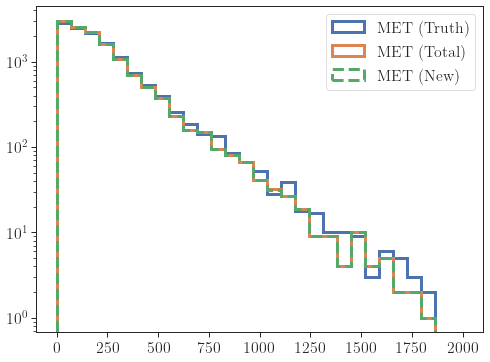

In [41]:
bins = np.linspace(0.,2000.,30)
fig = plt.figure(figsize=(8,6))
plt.hist(genMetDict['10ns'],bins=bins,label='MET (Truth)',histtype='step',linewidth=3)
plt.hist(metDict['10ns'],bins=bins,label='MET (Total)',histtype='step',linewidth=3)
plt.hist(newMetDict['10ns'],bins=bins,label='MET (New)',histtype='step',linewidth=3,linestyle='--')
plt.yscale('log')
plt.legend()
plt.show()

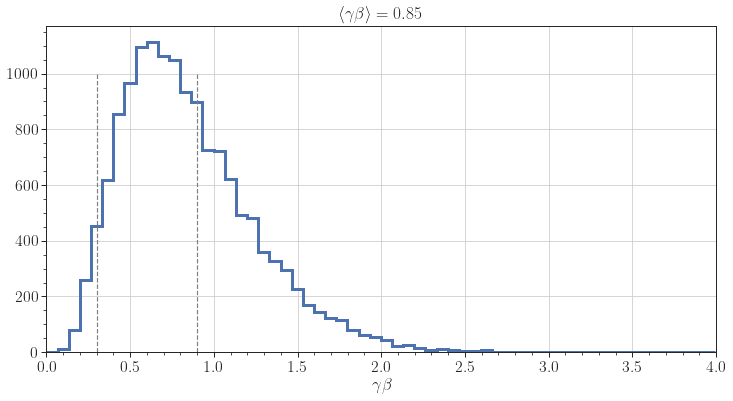

In [42]:
fig = plt.figure(figsize=(12,6))
bins = np.arange(0.,4.,0.0666)
plt.hist(gbetaDict['10ns'],bins=bins,histtype='step',linewidth=3)
plt.title(r'$\langle \gamma \beta \rangle = %1.2f$' %np.mean(gbetaDict['10ns']))
plt.xlabel(r'$\gamma \beta$')
plt.vlines(x=0.3,ymin=0.,ymax=1000,linestyles='--',color='gray')
plt.vlines(x=0.9,ymin=0.,ymax=1000,linestyles='--',color='gray')
plt.grid()
plt.minorticks_on()
plt.xlim(0.,4.)
plt.show()

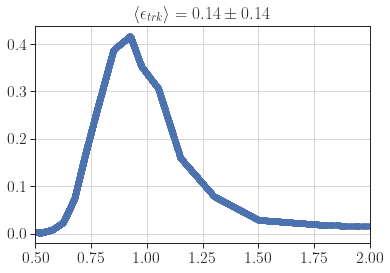

In [43]:
plt.scatter(gbetaDict['10ns'],trackEffDict['10ns'])
plt.xlim(0.5,2.0)
plt.grid()
plt.title(r'$\langle \epsilon_{trk} \rangle = %1.2f \pm %1.2f$' %(np.mean(trackEffDict['10ns']),np.std(trackEffDict['10ns'])))
plt.show()

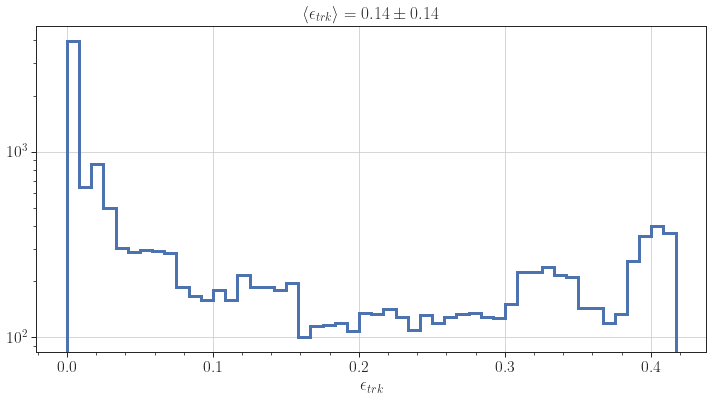

In [44]:
fig = plt.figure(figsize=(12,6))
plt.hist(trackEffDict['10ns'],bins=50,histtype='step',linewidth=3)
plt.title(r'$\langle \epsilon_{trk} \rangle = %1.2f \pm %1.2f$' %(np.mean(trackEffDict['10ns']),np.std(trackEffDict['10ns'])))
plt.xlabel(r'$\epsilon_{trk}$')
plt.grid()
plt.yscale('log')
plt.minorticks_on()
# plt.xlim(0.,4.)
plt.show()

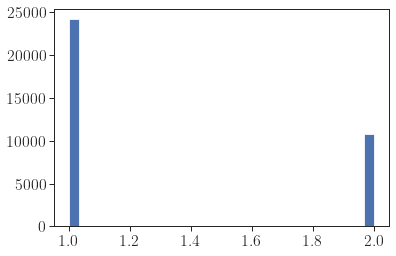

In [46]:
plt.hist(nhscps['10ns'],bins=30)
plt.show()

In [52]:
np.count_nonzero(np.array(nhscps['10ns']) == 1),np.count_nonzero(np.array(nhscps['10ns']) == 2)

(24164, 10814)

In [ ]:
xsecC1N1 = 0.240739 #fb
xsecC1C1 = 0.115645 #fb